### Random intercept vs fixed intercept simulations

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection

In [2]:
def convert_params_nb(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

### linear

In [368]:
n1 = 500
n2 = 1000

def get_linear_pvalues(ind1_intercept, ind2_intercept, delta_te, method):

    print(ind1_intercept, ind2_intercept)

    num_trials = 1000
    null_pvalues = np.zeros(num_trials)
    
    for i in range(num_trials):
        
        treatment_effect = 0.0

        if np.random.random() < 0.5:
            delta_te_random = -delta_te
        else:
            delta_te_random = delta_te
        
        ctrl_ind1 = ind1_intercept
        stim_ind1 = ind1_intercept + treatment_effect + delta_te_random/2
        
        ctrl_ind2 = ind2_intercept
        stim_ind2 = ind2_intercept + treatment_effect - delta_te_random/2
        
        ctrl_ind1_cells = stats.nbinom.rvs(*convert_params_nb(ctrl_ind1, 0.1), size=n1)
        stim_ind1_cells = stats.nbinom.rvs(*convert_params_nb(stim_ind1, 0.1), size=n1)
        
        ctrl_ind2_cells = stats.nbinom.rvs(*convert_params_nb(ctrl_ind2, 0.1), size=n2)
        stim_ind2_cells = stats.nbinom.rvs(*convert_params_nb(stim_ind2, 0.1), size=n2)
        # ctrl_ind1_cells = stats.norm.rvs(*(ctrl_ind1, 1), size=n1)
        # stim_ind1_cells = stats.norm.rvs(*(stim_ind1, 1), size=n1)
        
        # ctrl_ind2_cells = stats.norm.rvs(*(ctrl_ind2, 1), size=n2)
        # stim_ind2_cells = stats.norm.rvs(*(stim_ind2, 1), size=n2)
        
        ctrl_cells = np.concatenate([ctrl_ind1_cells, ctrl_ind2_cells])
        stim_cells = np.concatenate([stim_ind1_cells, stim_ind2_cells])
        
        if method == 't':
            tstat, pv = stats.ttest_ind(ctrl_cells, stim_cells, equal_var=False)
        elif method == 'lin':
            n_list = np.array([n1, n1, n2, n2])
            m = np.array([
                ctrl_ind1_cells.mean(),
                stim_ind1_cells.mean(),
                ctrl_ind2_cells.mean(),
                stim_ind2_cells.mean()
                
            ])
            v = np.array([
                ctrl_ind1_cells.var()/n1,
                stim_ind1_cells.var()/n1,
                ctrl_ind2_cells.var()/n2,
                stim_ind2_cells.var()/n2
            ])
            X = np.array([
                [1, -0.5, 0, 0],
                [1, -0.5, -0.5, 1],
                [1, 0.5, 0, 0],
                [1, 0.5, 0.5, 1]
            ])
            
            from sklearn.linear_model import LinearRegression
            # fit WLS using sample_weights
            WLS = LinearRegression()
            WLS.fit(X, m, sample_weight=n_list)
            
            diff_mean = WLS.coef_[-1]
            
            W = np.diag(1/v)
            beta_var_hat = np.diag(np.linalg.pinv(X.T@W@X))
            se = np.sqrt( beta_var_hat[-1] )
            
            z = diff_mean/se
            pv = stats.norm.sf(np.abs(z))*2
        null_pvalues[i] = pv
            
    sig_pvalues = np.zeros(num_trials)
    
    for i in range(num_trials):
        
        treatment_effect = 0.05
        
        if np.random.random() < 0.5:
            delta_te_random = -delta_te
        else:
            delta_te_random = delta_te
        
        ctrl_ind1 = ind1_intercept
        stim_ind1 = ind1_intercept + treatment_effect + delta_te_random/2
        
        ctrl_ind2 = ind2_intercept
        stim_ind2 = ind2_intercept + treatment_effect - delta_te_random/2
        
        ctrl_ind1_cells = stats.nbinom.rvs(*convert_params_nb(ctrl_ind1, 0.1), size=n1)
        stim_ind1_cells = stats.nbinom.rvs(*convert_params_nb(stim_ind1, 0.1), size=n1)
        
        ctrl_ind2_cells = stats.nbinom.rvs(*convert_params_nb(ctrl_ind2, 0.1), size=n2)
        stim_ind2_cells = stats.nbinom.rvs(*convert_params_nb(stim_ind2, 0.1), size=n2)

        # ctrl_ind1_cells = stats.norm.rvs(*(ctrl_ind1, 1), size=n1)
        # stim_ind1_cells = stats.norm.rvs(*(stim_ind1, 1), size=n1)
        
        # ctrl_ind2_cells = stats.norm.rvs(*(ctrl_ind2, 1), size=n2)
        # stim_ind2_cells = stats.norm.rvs(*(stim_ind2, 1), size=n2)
        
        ctrl_cells = np.concatenate([ctrl_ind1_cells, ctrl_ind2_cells])
        stim_cells = np.concatenate([stim_ind1_cells, stim_ind2_cells])

        if method == 't':
            tstat, pv = stats.ttest_ind(ctrl_cells, stim_cells, equal_var=False)
        elif method == 'lin':
            n_list = np.array([n1, n1, n2, n2])
            m = np.array([
                ctrl_ind1_cells.mean(),
                stim_ind1_cells.mean(),
                ctrl_ind2_cells.mean(),
                stim_ind2_cells.mean()
                
            ])
            v = np.array([
                ctrl_ind1_cells.var()/n1,
                stim_ind1_cells.var()/n1,
                ctrl_ind2_cells.var()/n2,
                stim_ind2_cells.var()/n2
            ])
            X = np.array([
                [1, -0.5, 0, 0],
                [1, -0.5, -0.5, 1],
                [1, 0.5, 0, 0],
                [1, 0.5, 0.5, 1]
            ])
            
            from sklearn.linear_model import LinearRegression
            # fit WLS using sample_weights
            WLS = LinearRegression()
            WLS.fit(X, m, sample_weight=n_list)
            
            diff_mean = WLS.coef_[-1]
            
            W = np.diag(1/v)
            beta_var_hat = np.diag(np.linalg.pinv(X.T@W@X))
            se = np.sqrt( beta_var_hat[-1] )
            
            z = diff_mean/se
            pv = stats.norm.sf(np.abs(z))*2
    
        sig_pvalues[i] = pv

    pvalues = np.concatenate([null_pvalues, sig_pvalues])
    _, fdr = fdrcorrection(pvalues)

    return null_pvalues, sig_pvalues
    return pvalues, fdr

In [369]:
def plot_fpr_power_curve(n, s, label=None):

    x, y = [], []
    for t in np.logspace(-5, 0, 30):

        x.append( (n<t).mean() )
        y.append( (s<t).mean() )
    plt.plot(x,y,'-o',label=label)

In [370]:
# # ln1, ls1 = get_linear_pvalues(1, 0, 0, method='t')

# pv_t, fdr_t = get_linear_pvalues(0.1, 0.6, 0.3, method='t')

# pv_l, fdr_l = get_linear_pvalues(0.1, 0.6, 0.3, method='lin')

In [373]:

ln1, ls1 = get_linear_pvalues(0.1, .2, 0, method='t')

ln2, ls2 = get_linear_pvalues(0.1, .2, 0.1, method='t')

ln3, ls3 = get_linear_pvalues(0.1, .2, 0, method='lin')

ln4, ls4 = get_linear_pvalues(0.1, .2, 0.1, method='lin')


0.1 0.2
0.1 0.2
0.1 0.2
0.1 0.2


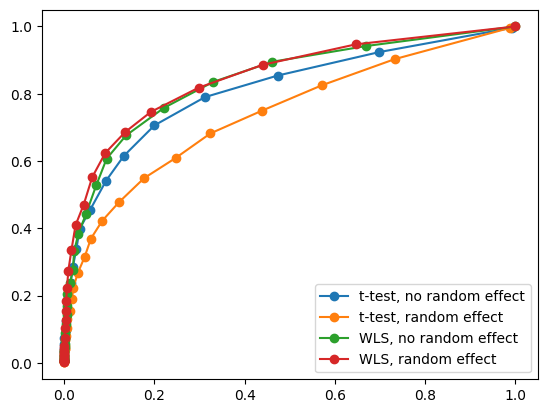

In [374]:

plot_fpr_power_curve(ln1, ls1,label='t-test, no random effect')

plot_fpr_power_curve(ln2, ls2, label='t-test, random effect')

plot_fpr_power_curve(ln3, ls3, label='WLS, no random effect')

plot_fpr_power_curve(ln4, ls4, label='WLS, random effect')

plt.legend()

### Log-linear

In [3]:
n1 = 500
n2 = 1000

def get_loglinear_pvalues(ind1_intercept, ind2_intercept, delta_te, method):

    print(ind1_intercept, ind2_intercept)

    num_trials = 1000
    null_pvalues = np.zeros(num_trials)
    
    for i in range(num_trials):
        
        treatment_effect = 0.0

        if np.random.random() < 0.5:
            delta_te_random = -delta_te
        else:
            delta_te_random = delta_te
        
        ctrl_ind1 = ind1_intercept
        stim_ind1 = ind1_intercept + treatment_effect + delta_te_random/2
        
        ctrl_ind2 = ind2_intercept
        stim_ind2 = ind2_intercept + treatment_effect - delta_te_random/2

        ctrl_ind1 = np.exp(ctrl_ind1)
        stim_ind1 = np.exp(stim_ind1)
        ctrl_ind2 = np.exp(ctrl_ind2)
        stim_ind2 = np.exp(stim_ind2)
        
        ctrl_ind1_cells = stats.nbinom.rvs(*convert_params_nb(ctrl_ind1, 0.1), size=n1)
        stim_ind1_cells = stats.nbinom.rvs(*convert_params_nb(stim_ind1, 0.1), size=n1)
        
        ctrl_ind2_cells = stats.nbinom.rvs(*convert_params_nb(ctrl_ind2, 0.1), size=n2)
        stim_ind2_cells = stats.nbinom.rvs(*convert_params_nb(stim_ind2, 0.1), size=n2)
        # ctrl_ind1_cells = stats.norm.rvs(*(ctrl_ind1, 1), size=n1)
        # stim_ind1_cells = stats.norm.rvs(*(stim_ind1, 1), size=n1)
        
        # ctrl_ind2_cells = stats.norm.rvs(*(ctrl_ind2, 1), size=n2)
        # stim_ind2_cells = stats.norm.rvs(*(stim_ind2, 1), size=n2)
        
        ctrl_cells = np.concatenate([ctrl_ind1_cells, ctrl_ind2_cells])
        stim_cells = np.concatenate([stim_ind1_cells, stim_ind2_cells])
        
        if method == 't':
            tstat, pv = stats.ttest_ind(np.log(ctrl_cells+1), np.log(stim_cells+1), equal_var=False)
        elif method == 'lin':
            n_list = np.array([n1, n1, n2, n2])
            m = np.array([
                ctrl_ind1_cells.mean(),
                stim_ind1_cells.mean(),
                ctrl_ind2_cells.mean(),
                stim_ind2_cells.mean()
                
            ])
            lm = np.log(m)
                       
            v = np.array([
                ctrl_ind1_cells.var()/n1,
                stim_ind1_cells.var()/n1,
                ctrl_ind2_cells.var()/n2,
                stim_ind2_cells.var()/n2
            ])
            se = np.sqrt(v)
            
            vlm = ( (np.log(m+se) - np.log(m-se))/2 )**2
            
            X = np.array([
                [1, -0.5, 0, 0],
                [1, -0.5, -0.5, 1],
                [1, 0.5, 0, 0],
                [1, 0.5, 0.5, 1]
            ])
            
            from sklearn.linear_model import LinearRegression
            # fit WLS using sample_weights
            WLS = LinearRegression()
            WLS.fit(X, lm, sample_weight=n_list)
            
            diff_mean = WLS.coef_[-1]
            
            W = np.diag(1/vlm)
            beta_var_hat = np.diag(np.linalg.pinv(X.T@W@X))
            se = np.sqrt( beta_var_hat[-1] )
            
            z = diff_mean/se
            pv = stats.norm.sf(np.abs(z))*2
    
        null_pvalues[i] = pv
            
    sig_pvalues = np.zeros(num_trials)
    
    for i in range(num_trials):
        
        treatment_effect = 0.25
        
        if np.random.random() < 0.5:
            delta_te_random = -delta_te
        else:
            delta_te_random = delta_te
        
        ctrl_ind1 = ind1_intercept
        stim_ind1 = ind1_intercept + treatment_effect + delta_te_random/2
        
        ctrl_ind2 = ind2_intercept
        stim_ind2 = ind2_intercept + treatment_effect - delta_te_random/2

        ctrl_ind1 = np.exp(ctrl_ind1)
        stim_ind1 = np.exp(stim_ind1)
        ctrl_ind2 = np.exp(ctrl_ind2)
        stim_ind2 = np.exp(stim_ind2)
        
        ctrl_ind1_cells = stats.nbinom.rvs(*convert_params_nb(ctrl_ind1, 0.1), size=n1)
        stim_ind1_cells = stats.nbinom.rvs(*convert_params_nb(stim_ind1, 0.1), size=n1)
        
        ctrl_ind2_cells = stats.nbinom.rvs(*convert_params_nb(ctrl_ind2, 0.1), size=n2)
        stim_ind2_cells = stats.nbinom.rvs(*convert_params_nb(stim_ind2, 0.1), size=n2)

        # ctrl_ind1_cells = stats.norm.rvs(*(ctrl_ind1, 1), size=n1)
        # stim_ind1_cells = stats.norm.rvs(*(stim_ind1, 1), size=n1)
        
        # ctrl_ind2_cells = stats.norm.rvs(*(ctrl_ind2, 1), size=n2)
        # stim_ind2_cells = stats.norm.rvs(*(stim_ind2, 1), size=n2)
        
        ctrl_cells = np.concatenate([ctrl_ind1_cells, ctrl_ind2_cells])
        stim_cells = np.concatenate([stim_ind1_cells, stim_ind2_cells])

        if method == 't':
            tstat, pv = stats.ttest_ind(np.log(ctrl_cells+1), np.log(stim_cells+1), equal_var=False)
        elif method == 'lin':
            n_list = np.array([n1, n1, n2, n2])
            m = np.array([
                ctrl_ind1_cells.mean(),
                stim_ind1_cells.mean(),
                ctrl_ind2_cells.mean(),
                stim_ind2_cells.mean()
                
            ])
            lm = np.log(m)
                       
            v = np.array([
                ctrl_ind1_cells.var()/n1,
                stim_ind1_cells.var()/n1,
                ctrl_ind2_cells.var()/n2,
                stim_ind2_cells.var()/n2
            ])
            se = np.sqrt(v)
            
            vlm = ( (np.log(m+se) - np.log(m-se))/2 )**2
            
            X = np.array([
                [1, -0.5, 0, 0],
                [1, -0.5, -0.5, 1],
                [1, 0.5, 0, 0],
                [1, 0.5, 0.5, 1]
            ])
            
            from sklearn.linear_model import LinearRegression
            # fit WLS using sample_weights
            WLS = LinearRegression()
            WLS.fit(X, lm, sample_weight=n_list)
            
            diff_mean = WLS.coef_[-1]
            
            W = np.diag(1/vlm)
            beta_var_hat = np.diag(np.linalg.pinv(X.T@W@X))
            se = np.sqrt( beta_var_hat[-1] )
            
            z = diff_mean/se
            pv = stats.norm.sf(np.abs(z))*2
    
        sig_pvalues[i] = pv

    pvalues = np.concatenate([null_pvalues, sig_pvalues])
    _, fdr = fdrcorrection(pvalues)

    return null_pvalues, sig_pvalues

In [4]:
def plot_fpr_power_curve(n, s, label=None):

    x, y = [], []
    for t in np.logspace(-5, 0, 30):

        x.append( (n<t).mean() )
        y.append( (s<t).mean() )
    plt.plot(x,y,'-o',label=label)

In [13]:

lln1, lls1 = get_loglinear_pvalues(0.1, .2, 0, method='t')

lln2, lls2 = get_loglinear_pvalues(0.1, .2, 0.8, method='t')

lln3, lls3 = get_loglinear_pvalues(0.1, .2, 0, method='lin')

lln4, lls4 = get_loglinear_pvalues(0.1, .2, 0.8, method='lin')


0.1 0.2
0.1 0.2
0.1 0.2
0.1 0.2


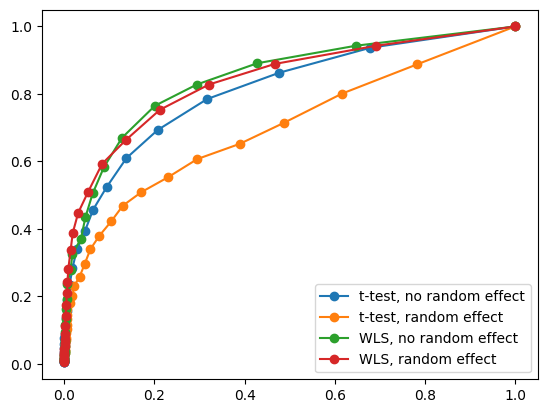

In [14]:

plot_fpr_power_curve(lln1, lls1,label='t-test, no random effect')

plot_fpr_power_curve(lln2, lls2, label='t-test, random effect')

plot_fpr_power_curve(lln3, lls3, label='WLS, no random effect')

plot_fpr_power_curve(lln4, lls4, label='WLS, random effect')

plt.legend()

### Randomized

In [32]:
n1 = 500
n2 = 1000
num_trials = 1000

def get_randomized_pvalues(method):

    ind1_intercepts = stats.norm.rvs(size=num_trials)
    ind2_intercepts = stats.norm.rvs(size=num_trials)
    delta_te = stats.norm.rvs(size=num_trials)

    null_pvalues = np.zeros(num_trials)
    
    for i in range(num_trials):

        ind1_intercept = ind1_intercepts[i]
        ind2_intercept = ind2_intercepts[i]
        treatment_effect = 0.0
        delta_te_random = delta_te[i]
        
        ctrl_ind1 = ind1_intercept
        stim_ind1 = ind1_intercept + treatment_effect + delta_te_random/2
        
        ctrl_ind2 = ind2_intercept
        stim_ind2 = ind2_intercept + treatment_effect - delta_te_random/2

        ctrl_ind1 = np.exp(ctrl_ind1)
        stim_ind1 = np.exp(stim_ind1)
        ctrl_ind2 = np.exp(ctrl_ind2)
        stim_ind2 = np.exp(stim_ind2)
        
        ctrl_ind1_cells = stats.nbinom.rvs(*convert_params_nb(ctrl_ind1, 0.1), size=n1)
        stim_ind1_cells = stats.nbinom.rvs(*convert_params_nb(stim_ind1, 0.1), size=n1)
        
        ctrl_ind2_cells = stats.nbinom.rvs(*convert_params_nb(ctrl_ind2, 0.1), size=n2)
        stim_ind2_cells = stats.nbinom.rvs(*convert_params_nb(stim_ind2, 0.1), size=n2)
        
        ctrl_cells = np.concatenate([ctrl_ind1_cells, ctrl_ind2_cells])
        stim_cells = np.concatenate([stim_ind1_cells, stim_ind2_cells])
        
        if method == 't':
            tstat, pv = stats.ttest_ind(np.log(ctrl_cells+1), np.log(stim_cells+1), equal_var=False)
        elif method == 'lin':
            n_list = np.array([n1, n1, n2, n2])
            m = np.array([
                ctrl_ind1_cells.mean(),
                stim_ind1_cells.mean(),
                ctrl_ind2_cells.mean(),
                stim_ind2_cells.mean()
                
            ])
            lm = np.log(m)
                       
            v = np.array([
                ctrl_ind1_cells.var()/n1,
                stim_ind1_cells.var()/n1,
                ctrl_ind2_cells.var()/n2,
                stim_ind2_cells.var()/n2
            ])
            se = np.sqrt(v)
            
            vlm = ( (np.log(m+se) - np.log(m-se))/2 )**2
            
            X = np.array([
                [1, -0.5, 0, 0],
                [1, -0.5, -0.5, 1],
                [1, 0.5, 0, 0],
                [1, 0.5, 0.5, 1]
            ])
            
            from sklearn.linear_model import LinearRegression
            # fit WLS using sample_weights
            WLS = LinearRegression()
            WLS.fit(X, lm, sample_weight=n_list)
            
            diff_mean = WLS.coef_[-1]
            
            W = np.diag(1/vlm)
            beta_var_hat = np.diag(np.linalg.pinv(X.T@W@X))
            se = np.sqrt( beta_var_hat[-1] )
            
            z = diff_mean/se
            pv = stats.norm.sf(np.abs(z))*2
    
        null_pvalues[i] = pv
            
    sig_pvalues = np.zeros(num_trials)
    
    for i in range(num_trials):

        ind1_intercept = ind1_intercepts[i]
        ind2_intercept = ind2_intercepts[i]
        treatment_effect = stats.norm.rvs(loc=1)
        delta_te_random = delta_te[i]
        
        ctrl_ind1 = ind1_intercept
        stim_ind1 = ind1_intercept + treatment_effect + delta_te_random/2
        
        ctrl_ind2 = ind2_intercept
        stim_ind2 = ind2_intercept + treatment_effect - delta_te_random/2

        ctrl_ind1 = np.exp(ctrl_ind1)
        stim_ind1 = np.exp(stim_ind1)
        ctrl_ind2 = np.exp(ctrl_ind2)
        stim_ind2 = np.exp(stim_ind2)
        
        ctrl_ind1_cells = stats.nbinom.rvs(*convert_params_nb(ctrl_ind1, 0.1), size=n1)
        stim_ind1_cells = stats.nbinom.rvs(*convert_params_nb(stim_ind1, 0.1), size=n1)
        
        ctrl_ind2_cells = stats.nbinom.rvs(*convert_params_nb(ctrl_ind2, 0.1), size=n2)
        stim_ind2_cells = stats.nbinom.rvs(*convert_params_nb(stim_ind2, 0.1), size=n2)
        
        ctrl_cells = np.concatenate([ctrl_ind1_cells, ctrl_ind2_cells])
        stim_cells = np.concatenate([stim_ind1_cells, stim_ind2_cells])

        if method == 't':
            tstat, pv = stats.ttest_ind(np.log(ctrl_cells+1), np.log(stim_cells+1), equal_var=False)
        elif method == 'lin':
            n_list = np.array([n1, n1, n2, n2])
            m = np.array([
                ctrl_ind1_cells.mean(),
                stim_ind1_cells.mean(),
                ctrl_ind2_cells.mean(),
                stim_ind2_cells.mean()
                
            ])
            lm = np.log(m)
                       
            v = np.array([
                ctrl_ind1_cells.var()/n1,
                stim_ind1_cells.var()/n1,
                ctrl_ind2_cells.var()/n2,
                stim_ind2_cells.var()/n2
            ])
            se = np.sqrt(v)
            
            vlm = ( (np.log(m+se) - np.log(m-se))/2 )**2
            
            X = np.array([
                [1, -0.5, 0, 0],
                [1, -0.5, -0.5, 1],
                [1, 0.5, 0, 0],
                [1, 0.5, 0.5, 1]
            ])
            
            from sklearn.linear_model import LinearRegression
            # fit WLS using sample_weights
            WLS = LinearRegression()
            WLS.fit(X, lm, sample_weight=n_list)
            
            diff_mean = WLS.coef_[-1]
            
            W = np.diag(1/vlm)
            beta_var_hat = np.diag(np.linalg.pinv(X.T@W@X))
            se = np.sqrt( beta_var_hat[-1] )
            
            z = diff_mean/se
            pv = stats.norm.sf(np.abs(z))*2
    
        sig_pvalues[i] = pv

    pvalues = np.concatenate([null_pvalues, sig_pvalues])
    _, fdr = fdrcorrection(pvalues)

    return null_pvalues, sig_pvalues

In [33]:
def plot_fpr_power_curve(n, s, label=None):

    x, y = [], []
    for t in np.logspace(-5, 0, 30):

        x.append( (n<t).mean() )
        y.append( (s<t).mean() )
    plt.plot(x,y,'-o',label=label)

In [34]:

rand_n1, rand_s1 = get_randomized_pvalues(method='t')

rand_n2, rand_s2 = get_randomized_pvalues(method='lin')


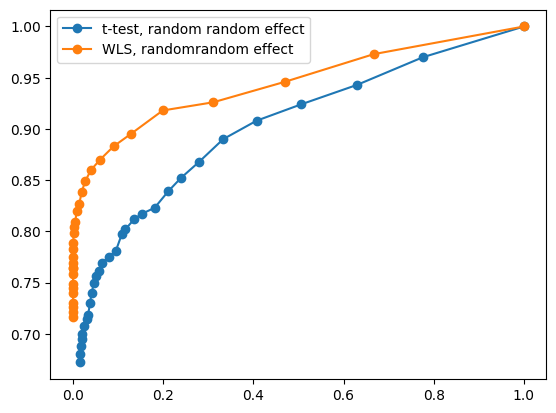

In [35]:

plot_fpr_power_curve(rand_n1, rand_s1,label='t-test, random random effect')

plot_fpr_power_curve(rand_n2, rand_s2, label='WLS, randomrandom effect')

plt.legend()